In [64]:
from pathlib import Path
from scipy.special import ellipk
import numpy as np
import matplotlib.pylab as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["mathtext.fontset"] = "cm"

eps0 = 8.85418781  # pF/m

substrate_thickness = 500
eps = 3.9
unit = 20
gap = 6.5
factor = np.pi / (4 * substrate_thickness)
s1 = np.sinh(factor * (3. * unit - gap))
s2 = np.sinh(factor * (unit + gap))
s3 = np.sinh(factor *  (unit - gap))
mod_m = (s1/s2 - 1) * (s1/s2 + 1) / ((s1/s3 - 1) * (s1/s3 + 1))
mod_a = ((unit - gap) / (unit + gap)) ** 2 * 2 * (unit - gap) / (2 * unit - gap)
ellint_ratio_a = ellipk(mod_a) / ellipk(1 - mod_a)
ellint_ratio_m = ellipk(mod_m) / ellipk(1 - mod_m)
cap0 = eps0 * 49 * 1e-3 * ellint_ratio_a
#cap = 2 * eps0 * 49 * 1e-3 * (ellint_ratio_a + 0.5 * (eps - 1) * ellint_ratio_m)
cap = cap0 + eps * cap0
print(cap)

1.581706690002057


In [65]:
def susceptibility_noninteracting(temperature: np.ndarray, coupling_energy: float):
        sech = 1.0 / np.cosh(coupling_energy / (2.0 * temperature))
        return sech * sech



def fitting_function(temperature: np.ndarray, angular_frequency, curie_temperature: float,
                     alpha: float,
                     ln_attempt_time1: float,
                     activation_energy1: float,
                     coupling_energy1: float,
                     populations1: np.ndarray,
                     emat0: float, emat1: float,
                     bare0: float, bare1: float, bare2: float, 
                     td0: float, td1: float, td2: float):
    
    tau1 = np.exp(ln_attempt_time1 + (activation_energy1) / temperature)     # shape (num_relax_times, 1, 1)
    temperature_300 = temperature - 300.0
    temperature_curie_inv = 1. / (temperature - curie_temperature)
    omega_tau1 = angular_frequency * tau1
    x = np.log(omega_tau1)
    alpha_comp = 1. - alpha
    chi_denom = np.cosh(alpha_comp * x) + np.sin(0.5 * np.pi * alpha)
    real_chi = 1 - np.sinh(alpha_comp * x) / chi_denom
    imag_chi = np.cos(0.5 * np.pi * alpha) / chi_denom

    thermo = populations1 * susceptibility_noninteracting(temperature, coupling_energy1) * temperature_curie_inv
    real1 = thermo * real_chi
    imag1 = thermo * imag_chi
    # geometric_factor = bare0 / 4.8
    real_eps = ((emat0 - 1) + emat1 * temperature_300 + real1)  # * geometric_factor
    imaginary_eps = imag1  # * geometric_factor
    capacitance = cap0 * (1 + real_eps)
    imaginary_capacitance = cap0 * imaginary_eps
    loss_tangent = imaginary_capacitance / capacitance
    return capacitance, loss_tangent

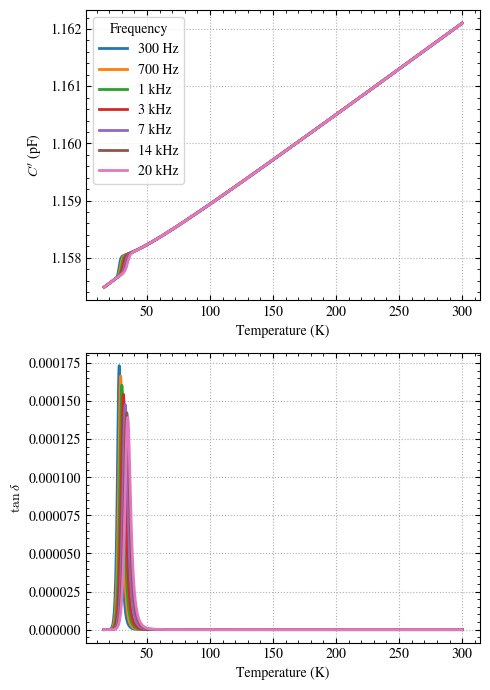

In [87]:
temperature = np.linspace(16, 300, 1000)
frequencies = np.array([300, 700, 1400, 3000, 7000, 14000, 20000])
freq_num = len(frequencies)
temperature = np.stack([temperature] * freq_num).T

#colors = ["k", "b", "r", ]

cole = 0.
eps0 = 3.6
pop = 1.5e-2
eps1 = 5e-5
assym = 0
activation_energy = 600
capacitance, loss_tangent = fitting_function(temperature, frequencies * 2 * np.pi, 0, cole, -29,
                                             activation_energy, assym, pop, eps0, eps1, 0, 0, 0, 0, 0, 0)

fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# axes[0].set_title()
for ax in axes:
    ax.grid(linestyle='dotted')
    ax.set_xlabel('Temperature (K)')
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

axes[0].set_ylabel(r"$C'$ (pF)")
axes[1].set_ylabel(r"$\tan\delta$")
for ii in range(freq_num):
    freq_name = str(int(frequencies[ii]))
    if len(freq_name) > 3:
        freq_name = freq_name[:-3] + " kHz"
    else:
        freq_name += " Hz"
    axes[0].plot(temperature[:, ii], capacitance[:, ii], linewidth=2, label=freq_name)#, color=colors[ii])
    axes[1].plot(temperature[:, ii], loss_tangent[:, ii], linewidth=2)#, color=colors[ii])
axes[0].legend(title="Frequency")
fig.tight_layout()
# fig.savefig("example_debye.pdf", dpi=300, bbox_inches="tight")